# ECUACIÓN DEL CALOR PLACA

In [22]:
Threads.nthreads()

24

In [23]:
using Gridap
import Gridap: ∇

## Solución exacta

In [24]:
#En primer lugar vamos a definir la expresión de la solución ya conocida

u_exacta(x) = (x[1]*x[1]-x[1])*(x[2]*x[2]-x[2])*t

u_exacta (generic function with 1 method)

In [25]:
#Mallado
const global domain = (0,1,0,1)
const global partition = (20,20)
model = CartesianDiscreteModel(domain,partition)
model=simplexify(model)
const global trian = Triangulation(model)
const global degree = 1
const global quad = CellQuadrature(trian,degree)
const global N_intervalos = 10;

const global dt_ex = 1/N_intervalos;

In [89]:
for i=1:N_intervalos+1
    t=(i-1)*dt_ex
    writevtk(trian,"Sol_exacta$(lpad(i,2,'0'))",cellfields=["u_exacta" => u_exacta])
end 

InterruptException: InterruptException:

## Solución numérica

In [26]:
#Parámetros
t = 0.
g(x) = 0  #valor en la frontera
f(x) = (x[1]*x[1]-x[1])*(x[2]*x[2]-x[2]) - 2*(x[2]*x[2]-x[2])*t - (x[1]*x[1]-x[1])*2*t  #fuente de calor
u0(x) = 0.  #valor inicial

const global t_init = 0.
const global t_end = 1.
#n_t = 10;
#dt = (t_end - t_init)/n_t;
const global n_iter = 5;
const global T = LinRange(t_init, t_end, N_intervalos+1)


11-element LinRange{Float64}:
 0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0

In [27]:
#Espacio de funciones
const global order = 1
V0 = TestFESpace(
  reffe=:Lagrangian, order=order, valuetype=Float64,
  conformity=:H1, model=model, dirichlet_tags="boundary")

U = TrialFESpace(V0,g)


TrialFESpace()

In [28]:
function EulerMEF(t_init,t_end,n_t,u0)
    dt = (t_end - t_init)/n_t
    u_sol = u0
    t = t_init
    f(x) = (x[1]*x[1]-x[1])*(x[2]*x[2]-x[2]) - 2*(x[2]*x[2]-x[2])*t - (x[1]*x[1]-x[1])*2*t
    
    a(u,v) = dt * beta*∇(v)*∇(u) + u*v
    b(v) = v*dt*f + v*u0
    
    for i=1:n_t
        t += dt
        t_Ω = AffineFETerm(a,b,trian,quad)
        op = AffineFEOperator(U,V0,t_Ω)
        u_sol = solve(op)
        
        u0 = u_sol
    end
    return u_sol
end 
    

EulerMEF (generic function with 1 method)

In [29]:
t_n_f = 50;
const global t_n_c = 10;

@inline F(t1, t0, u0) =  EulerMEF(t0, t1, t_n_f,u0)
@inline G(t1, t0, u0) =  EulerMEF(t0, t1, t_n_c,u0)

G (generic function with 1 method)

In [30]:
#Función de Gridap con el valor inicial 
f2(x) = 0

const global U_u0 = TrialFESpace(V0,g)
const global beta =1.

a_u0(u,v) =  u*v
b_u0(v) = v*f2 

const global t_Ω_u0 = AffineFETerm(a_u0,b_u0,trian,quad)
const global op_u0 = AffineFEOperator(U_u0,V0,t_Ω_u0)

const global u0_guardar = solve(op_u0)

typeof(u0_guardar)

Gridap.FESpaces.SingleFieldFEFunction{true}

In [68]:
function EDP_secuencial()
    U = Array{Gridap.Geometry.GenericCellField{true},2}(undef, N_intervalos+1, n_iter+1);
    F_sol = Array{Gridap.Geometry.GenericCellField{true},1}(undef, N_intervalos+1);

    # 1.a) Inicialización (aproximción grosera)
    U[1,1] = 1*u0_guardar

    for n=1:N_intervalos
        U[n+1,1] = 1*G( T[n+1],T[n],U[n,1] )
    end
        
    # 1.b) Inicialización etapas parareal
    for k=1:n_iter
        U[1,k+1] = 1*u0_guardar
    end

    # 2) Bucle parareal
    for k=1:n_iter
 
        # 2.a) Aproximación fina (paralela) en cada subintervalo
        @inbounds for n = 1:N_intervalos
            F_sol[n] = 1*F( T[n+1], T[n], U[n,k] )
        end
        
        # 2.b) Corrección secuencial
        @inbounds for n = 1:N_intervalos
            U[n+1, k+1] = F_sol[n] + G( T[n+1], T[n], U[n,k+1] ) - G( T[n+1], T[n], U[n,k] )
        end
    end
    
    return U
    
end

EDP_secuencial (generic function with 1 method)

In [31]:
function EDP_parareal()
    U = Array{Gridap.Geometry.GenericCellField{true},2}(undef, N_intervalos+1, n_iter+1);
    F_sol = Array{Gridap.Geometry.GenericCellField{true},1}(undef, N_intervalos+1);

    # 1.a) Inicialización (aproximción grosera)
    U[1,1] = 1*u0_guardar

    for n=1:N_intervalos
        U[n+1,1] = 1*G( T[n+1],T[n],U[n,1] )
    end
        
    # 1.b) Inicialización etapas parareal
    @inbounds Threads.@threads for k=1:n_iter
        U[1,k+1] = 1*u0_guardar
    end

    # 2) Bucle parareal
    for k=1:n_iter
 
        # 2.a) Aproximación fina (paralela) en cada subintervalo
        @inbounds Threads.@threads for n = 1:N_intervalos
            F_sol[n] = 1*F( T[n+1], T[n], U[n,k] )
        end
        
        # 2.b) Corrección secuencial
        @inbounds for n = 1:N_intervalos
            U[n+1, k+1] = F_sol[n] + G( T[n+1], T[n], U[n,k+1] ) - G( T[n+1], T[n], U[n,k] )
        end
    end
    
    return U
    
end

EDP_parareal (generic function with 1 method)

In [11]:
function EulerMEF2(t_init,t_end,n_t,u0,t_n_f)
    U_save = Array{Gridap.Geometry.GenericCellField{true},1}(undef, N_intervalos+1);
    U_save[1] = 1*u0_guardar
    
    cont = 2
    
    dt = (t_end - t_init)/n_t
    u_sol = u0
    t = t_init
    f(x) = (x[1]*x[1]-x[1])*(x[2]*x[2]-x[2]) - 2*(x[2]*x[2]-x[2])*t - (x[1]*x[1]-x[1])*2*t
    
    a(u,v) = dt * beta*∇(v)*∇(u) + u*v
    b(v) = v*dt*f + v*u0
    
    for i=1:n_t
        t += dt
        t_Ω = AffineFETerm(a,b,trian,quad)
        op = AffineFEOperator(U,V0,t_Ω)
        u_sol = solve(op)
        if i % t_n_f == 0
            U_save[cont] = 1*u_sol
            cont += 1
        end
        u0 = u_sol
    end
    return U_save
end 

EulerMEF2 (generic function with 1 method)

In [99]:
iteraciones_f = t_n_f*N_intervalos

6000

In [103]:
@time U3 = EulerMEF2(t_init, t_end,iteraciones_f,u0_guardar,t_n_f);

 58.045802 seconds (138.98 M allocations: 14.294 GiB, 9.26% gc time)


In [32]:
@time U2 = EDP_parareal();

 33.465567 seconds (186.70 M allocations: 13.892 GiB, 20.55% gc time)


In [15]:
for i=1:N_intervalos+1
    sol = U2[i,end]
    writevtk(trian,"Sol_numerica$(lpad(i,2,'0'))",cellfields=["sol" => sol])
end 

## Error

In [16]:
for i=1:N_intervalos+1
    t=(i-1)*dt_ex
    e = u_exacta - U2[i,end]
    writevtk(trian,"Error_t$(lpad(i,2,'0'))",cellfields=["e" => e])
end 

In [33]:
# Error en norma L2 para cada subintervalo temporal

l2(w) = w*w


error_L2 = Array{Any,1}(undef, N_intervalos+1);

for i=1:N_intervalos+1
    el2 = sqrt(sum( integrate(l2(U2[i,end]-u_exacta),trian,quad) ))
    error_L2[i] = el2
end 

In [18]:
using Plots

In [67]:
plotly()

plot(T,error_L2,
    shape=:auto,
    xlabel="T",ylabel="error", tickfont=(13, :black),legend = nothing,guidefont = (18, :black),gridlinewidth=2)

<!DOCTYPE html>
 
 
 Plots.jl

In [21]:
for i=1:n_iter+1
    t=1.
    e = u_exacta - U2[end,i]
    writevtk(trian,"Error_k$(lpad(i,2,'0'))",cellfields=["e" => e])
end 

In [22]:
# Error en norma L2 para cada subintervalo temporal

l2(w) = w*w


error_L2_k = Array{Any,1}(undef, n_iter+1);

for i=1:n_iter+1
    el2 = sqrt(sum( integrate(l2(U2[end,i]-u_exacta),trian,quad) ))
    error_L2_k[i] = el2
end 

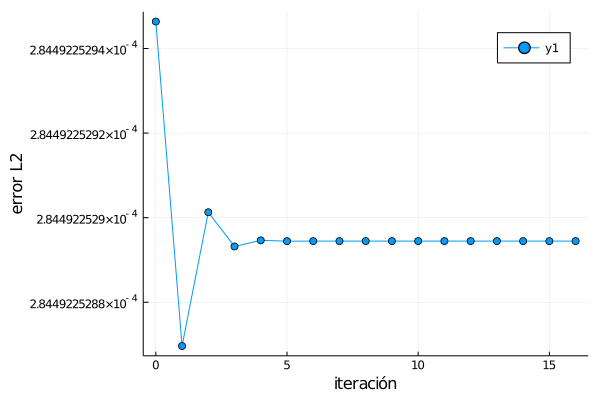

In [23]:
K = LinRange(0, n_iter, n_iter+1)
plot(K,error_L2_k,
    shape=:auto,
    xlabel="iteración",ylabel="error L2")

## Comparación tiempo
### N_intervalos = nucleos/2

In [24]:
time_8= Array{Float64,2}(undef, 5,2);
for i=1:5
    t_n_f = 50 +10*(i-1)
    tiempo = @elapsed EDP_secuencial()
    time_8[i,1] = tiempo
    tiempo = @elapsed EDP_parareal()
    time_8[i,2] = tiempo
end

InterruptException: InterruptException:

In [25]:
time_array=LinRange(50, 100, 5)
plotly()
plot(time_array,  time_8, label = ["secuencial" "paralelo"], title = "N_intervalos = mitad de núcleos", xlabel="iteraciones finas", ylabel="tiempo (s)")

┌ Info: For saving to png with the Plotly backend ORCA has to be installed.
└ @ Plots /home/noelia/.julia/packages/Plots/ninUP/src/backends.jl:375


<!DOCTYPE html>
 
 
 Plots.jl

### N_intervalos = núcleos

In [26]:
time_16= Array{Float64,2}(undef, 5,2);
for i=1:5
    t_n_f = 50 +10*(i-1)
    tiempo = @elapsed EDP_secuencial()
    time_16[i,1] = tiempo
    tiempo = @elapsed EDP_parareal()
    time_16[i,2] = tiempo
end

InterruptException: InterruptException:

In [27]:
plotly()
plot(time_array,  time_16, label = ["secuencial" "paralelo"], title = "N_intervalos = núcleos", xlabel="iteraciones finas", ylabel="tiempo (s)")

<!DOCTYPE html>
 
 
 Plots.jl

## Comparación tiempos con Euler

In [20]:
time_20= Array{Float64,2}(undef, 4,2);
for i=1:4
    t_n_f = 100 +200*(i-1)
    iteraciones_f = t_n_f*N_intervalos
    tiempo = @elapsed  EulerMEF2(t_init, t_end,iteraciones_f,u0_guardar,t_n_f)
    time_20[i,1] = tiempo
    tiempo = @elapsed EDP_parareal()
    time_20[i,2] = tiempo
end

In [19]:
time_array=LinRange(100, 700, 4)

4-element LinRange{Float64}:
 100.0,300.0,500.0,700.0

In [73]:
plotly()
plot(time_array,  time_20, label = ["Euler" "Parareal"], title = "Número de subintervalos: 20", xlabel="iteraciones finas", ylabel="tiempo (s)", tickfont=(11, :black),guidefont = (13, :black),legendfont=(12,:black),inset = (1, bbox(0.5, 0.0, 0.4, 0.4)))

<!DOCTYPE html>
 
 
 Plots.jl

In [135]:
begin
    plot(time_array,  time_20, label = ["Euler" "Parareal"], title = "Número de subintervalos: 20", xlabel="iteraciones finas", ylabel="tiempo (s)", tickfont=(11, :black),guidefont = (13, :black),legendfont=(15,:black))
    lens!([272.5, 277.5], [52.5, 53.5], inset = (1, bbox(0.1, 0.1, 0.35, 0.35, :top, :left)))
end

<!DOCTYPE html>
 
 
 Plots.jl